# Config file of an example using LSTM-KF-RL on a synthetic time series
This file include 
1. synthetic data generation
2. training BDLM-LSTM model with hyper-parameters-free AR
3. check if the BDLM-LSTM model is correct (LSTM, AR, AA)
4. generate time series for RL agent training
5. train RL agents
6. evaluate the performance of RL agents

In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import copy

from tqdm import tqdm
from datetime import datetime, timedelta
from src.RL_functions.generate_synthetic_time_series import *
from examples.data_loader import TimeSeriesDataloader
from pytagi import Normalizer as normalizer
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm
import pytagi.metric as metric
from pytagi import Normalizer


## 1. Generate synthetic time series with Kernel regression

In [2]:
components = ['acceleration', 'kernel', 'ar']
hyperparameters = {'acceleration': {'process_error_var': 0.0, 'constant_LA_process_error': 0.0 },
                   'kernel': {'period': 52, 'kernel_length': 0.5, 'sigma_KR0': 0, 'sigma_KR1': 0, 'n_cp':10},
                   'ar': {'phi': 0.7, 'process_error_var': 0.2**2},
                #    'ar': {'phi': 0.75, 'process_error_var': 0**2},
                   'observation': {'error': 1e-20}}
x_init = {'mu': np.array([0.294, 0.001, 0, 0, -0.35, -0.25, 1.90, 2.81, -0.03, 0.30, -0.35, 1.70, 0.10, -0.15, -0.05]), \
          'var': np.diag([1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 1E-15, 6.36E-05])}

total_time_steps = int(52*40+1)
time_step_interval = 7
time_covariates = ['week_of_year']
np.random.seed(2024)
syn_ts = generate_time_series(components = components,\
                                      time_step = time_step_interval, \
                                      hyperparameters = hyperparameters,\
                                      num_steps = total_time_steps, \
                                      x_init = x_init,\
                                    #   insert_anomaly = True,\
                                    #   anomaly_timesteps = [1000],\
                                    #   anomaly_LT=[-0.003])
                                      insert_anomaly = False)

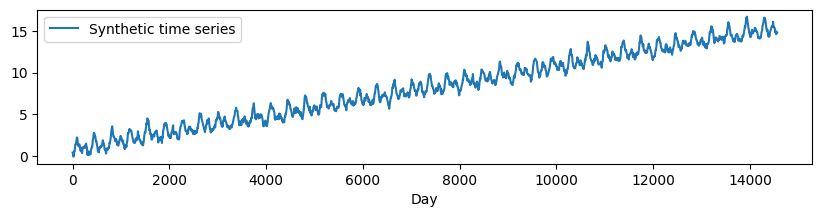

In [3]:
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 2))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

ax0.plot(syn_ts['timesteps'], syn_ts['y'], label='Synthetic time series', alpha=1)
ax0.set_xlabel('Day')
ax0.legend()

### Export the generated data to csv
For the compatibility with LSTM

In [4]:
# Export data to csv file
training_idx = hyperparameters['kernel']['period'] * 4
val_idx = hyperparameters['kernel']['period'] * 5

start_datetime = datetime(2005, 11, 6, 12, 0, 0)  # Start datetime
datetime_values = generate_datetime_values(start_datetime, len(syn_ts['timesteps']), time_step_interval)

# # Training set generation
train_observations = syn_ts['y'][0: training_idx]
train_datetime_values = datetime_values[0: training_idx]

# Validation set generation
val_observations = syn_ts['y'][training_idx-26:val_idx]
val_datetime_values = datetime_values[training_idx-26:val_idx]

# Test set generation
test_observations = syn_ts['y'][val_idx-26:]
test_datetime_values = datetime_values[val_idx-26:]

# Save training csv files
with open('data/synthetic_ts/syn_train_obs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['syn_obs'])
    for i in range(len(train_datetime_values)):
        writer.writerow([round(float(train_observations[i]), 3)])
with open('data/synthetic_ts/syn_train_datetime.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['date_time'])
    for i in range(len(train_datetime_values)):
        writer.writerow([train_datetime_values[i]])

# Save validation csv files
with open('data/synthetic_ts/syn_val_obs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['syn_obs'])
    for i in range(len(val_datetime_values)):
        writer.writerow([round(float(val_observations[i]), 3)])
with open('data/synthetic_ts/syn_val_datetime.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['date_time'])
    for i in range(len(val_datetime_values)):
        writer.writerow([val_datetime_values[i]])

# Save test csv files
with open('data/synthetic_ts/syn_test_obs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['syn_obs'])
    for i in range(len(test_datetime_values)):
        writer.writerow([round(float(test_observations[i]), 3)])
with open('data/synthetic_ts/syn_test_datetime.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['date_time'])
    for i in range(len(test_datetime_values)):
        writer.writerow([test_datetime_values[i]])

## 2. Train BDLM
The components are AA + AR + LSTM. The AR component here learns automatically the phi_AR and sigma_AR

### BDLM training configuration

In [5]:
num_epochs: int = 50
batch_size: int = 1
sigma_v: float = 1E-12

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

train_dtl = TimeSeriesDataloader(
    x_file="data/synthetic_ts/syn_train_obs.csv",
    date_time_file="data/synthetic_ts/syn_train_datetime.csv",
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
)
val_dtl = TimeSeriesDataloader(
    x_file="data/synthetic_ts/syn_val_obs.csv",
    date_time_file="data/synthetic_ts/syn_val_datetime.csv",
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    x_mean=train_dtl.x_mean,
    x_std=train_dtl.x_std,
    time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
)
test_dtl = TimeSeriesDataloader(
    x_file="data/synthetic_ts/syn_test_obs.csv",
    date_time_file="data/synthetic_ts/syn_test_datetime.csv",
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    x_mean=train_dtl.x_mean,
    x_std=train_dtl.x_std,
    time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
)

### Use a first-order regression model to estimate the initial state

Initial level: -0.9156064583167334, Initial speed: 0.008846439210789687


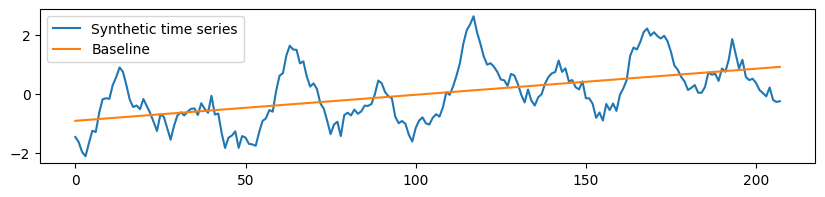

In [6]:
x_data = np.array(pd.read_csv("data/synthetic_ts/syn_train_obs.csv", skiprows=1, delimiter=",", header=None).values.T[0])
x_data = normalizer.standardize(data=x_data, mu=train_dtl.x_mean[output_col], std=train_dtl.x_std[output_col])
time_idx = np.arange(0, len(x_data))

# Fit a first-order regression model, ax+b, to the data x_data, y_data
valid_indices = ~np.isnan(x_data)
time_idx_filtered = time_idx[valid_indices]
x_data_filtered = x_data[valid_indices]
speed_init, level_init = np.polyfit(time_idx_filtered, x_data_filtered, 1)

print(f"Initial level: {level_init}, Initial speed: {speed_init}")

# Plot x_data
fig = plt.figure(figsize=(10, 2))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.plot(time_idx, x_data, label='Synthetic time series', alpha=1)
# Plot baseline with initial level and speed
baseline = level_init + speed_init * time_idx
ax0.plot(time_idx, baseline, label='Baseline', alpha=1)
ax0.legend()

### Training

In [7]:
# Network
net = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)
# #net.to_device("cuda")

# # # State-space models: for baseline hidden states
LA_var_stationary = 1e-17*1/(1-0.999**2)
# # Autoregressive acceleration + online AR
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([level_init, speed_init, 0, 0.5, -0.05]),
    SzB = np.array([1E-16, 1E-10, LA_var_stationary, 0.5**2, 0.15**2]),
    use_auto_AR = True,
    mu_W2b_init = 1**2,
    var_W2b_init = 1**2,
)

In [8]:
# Training
mses = []

pbar = tqdm(range(num_epochs), desc="Training Progress")
for epoch in pbar:
    batch_iter = train_dtl.create_data_loader(batch_size, shuffle=False)

    # Decaying observation's variance
    # sigma_v = exponential_scheduler(
    #     curr_v=1E-12, min_v=1E-12, decaying_factor=1, curr_iter=epoch
    # )
    sigma_v = sigma_v
    var_y = np.full((batch_size * len(output_col),), sigma_v**2, dtype=np.float32)

    # Initialize list to save
    hybrid.init_ssm_hs()
    mu_preds_lstm = []
    var_preds_lstm = []
    mu_preds_unnorm = []
    obs_unnorm = []
    mu_phiar = []
    var_phiar = []
    mu_aa = []
    var_aa = []
    mu_sigma_ar = []
    var_sigma_ar = []
    mu_ar = []
    var_ar = []

    for x, y in batch_iter:
        mu_x, var_x = process_input_ssm(
            mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
            input_seq_len = input_seq_len, num_features = num_features,
            )

        # Feed forward
        y_pred, _, z_pred, Sz_pred, m_pred, v_pred = hybrid(mu_x, var_x)
        # Backward
        hybrid.backward(mu_obs = y, var_obs = var_y)

        # Training metric
        pred = normalizer.unstandardize(
            y_pred.flatten(), train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )
        obs = normalizer.unstandardize(
            y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )
        mse = metric.mse(pred, obs)
        mses.append(mse)
        mu_preds_lstm.extend(m_pred)
        var_preds_lstm.extend(v_pred)
        obs_unnorm.extend(y)
        mu_preds_unnorm.extend(y_pred)
        mu_phiar.append(z_pred[-3].item())
        var_phiar.append(Sz_pred[-3][-3])
        mu_aa.append(z_pred[2].item())
        var_aa.append(Sz_pred[2][2])
        mu_ar.append(z_pred[-2].item())
        var_ar.append(Sz_pred[-2][-2])
        mu_sigma_ar.append(np.sqrt(hybrid.mu_W2b_posterior.item()))
        var_sigma_ar.append(np.sqrt(hybrid.var_W2b_posterior.item()))

    # Smoother
    hybrid.smoother()

    mu_smoothed = np.array(hybrid.mu_smoothed)
    cov_smoothed = np.array(hybrid.cov_smoothed)

    # Progress bar
    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs}| mse: {np.nanmean(mses):>7.2f}",
        refresh=True,
    )

# print the value of AR
print(f"phi_AR: {mu_phiar[-1]}")

# -------------------------------------------------------------------------#
# Test on validation set
val_batch_iter = val_dtl.create_data_loader(batch_size, shuffle=False)

# Initialize list to save
mu_preds = []
var_preds = []
y_val = []
obs_val_unnorm = []
#

for x, y in val_batch_iter:
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len,num_features = num_features,
    )
    # Feed forward
    y_pred, Sy_red, z_pred, Sz_pred, m_pred, v_pred = hybrid(mu_x, var_x)
    hybrid.backward(mu_obs = np.nan, var_obs = np.nan, train_LSTM=False)

    mu_preds.extend(y_pred)
    var_preds.extend(Sy_red + sigma_v**2)
    y_val.extend(y)
    mu_preds_lstm.extend(m_pred)
    var_preds_lstm.extend(v_pred)

mu_preds = np.array(mu_preds)
std_preds = np.array(var_preds) ** 0.5
y_val = np.array(y_val)
obs_val_unnorm = y_val
mu_preds_unnorm_val = mu_preds
std_preds_unnorm_val = std_preds

mu_preds = normalizer.unstandardize(
    mu_preds, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
)
std_preds = normalizer.unstandardize_std(std_preds, train_dtl.x_std[output_col])

y_val = normalizer.unstandardize(
    y_val, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
)

# Compute log-likelihood
mse = metric.mse(mu_preds, y_val)
log_lik = metric.log_likelihood(
    prediction=mu_preds, observation=y_val, std=std_preds
)

#
obs = np.concatenate((obs_unnorm,obs_val_unnorm), axis=0)
idx_train = range(0,len(obs_unnorm))

idx_val = range(len(obs_unnorm),len(obs))
idx = np.concatenate((idx_train,idx_val),axis=0)
mu_preds_unnorm_val = mu_preds_unnorm_val.flatten()
std_preds_unnorm_val = std_preds_unnorm_val.flatten()

print("#############")
print(f"MSE           : {mse: 0.2f}")
print(f"Log-likelihood: {log_lik: 0.2f}")

Epoch 50/50| mse:    0.04: 100%|██████████| 50/50 [01:21<00:00,  1.62s/it]


phi_AR: 0.6352801326390148
#############
MSE           :  1.05
Log-likelihood: -12.53


## 3. Check if the BDLM-LSTM model is correct (LSTM, AR, AA)

### Check if LSTM and AR is correct

Text(0, 0.5, 'AR')

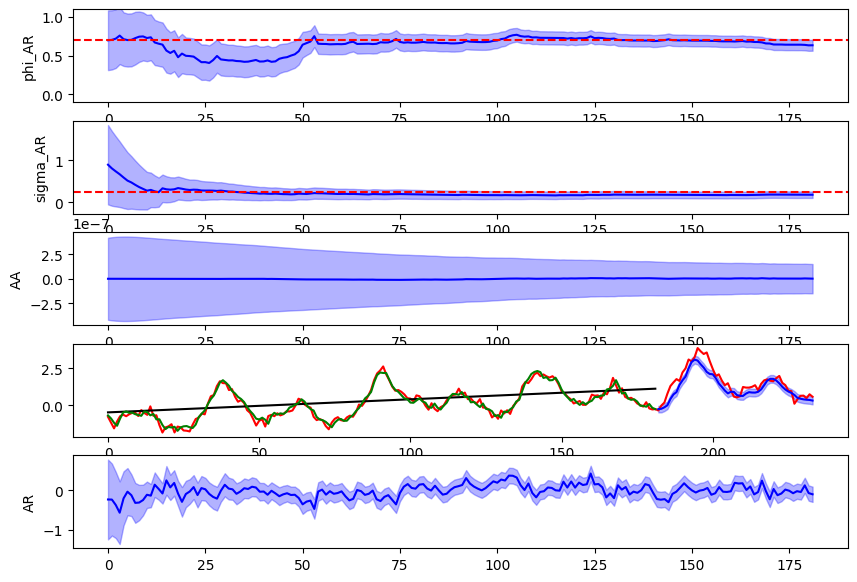

In [87]:
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(5, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax0.plot(np.arange(len(mu_phiar)),mu_phiar,color='b',label=r"AR")
ax0.fill_between(np.arange(len(mu_phiar)), np.array(mu_phiar) - np.sqrt(var_phiar), np.array(mu_phiar) + np.sqrt(var_phiar), color='blue', alpha=0.3, label='±1 SD')
ax0.axhline(y=hyperparameters['ar']['phi'], color='r', linestyle='--', label='True phi')
ax0.set_ylim(-0.1, 1.1)
ax0.set_ylabel('phi_AR')
ax1.plot(np.arange(len(mu_sigma_ar)),mu_sigma_ar,color='b',label=r"AR")
ax1.fill_between(np.arange(len(mu_sigma_ar)), np.array(mu_sigma_ar) - np.sqrt(var_sigma_ar), np.array(mu_sigma_ar) + np.sqrt(var_sigma_ar), color='blue', alpha=0.3, label='±1 SD')
ax1.axhline(y=np.sqrt(hyperparameters['ar']['process_error_var']) / (train_dtl.x_std[output_col] + 1e-10),
            color='r', linestyle='--', label='True sigma_AR')
ax1.set_ylabel('sigma_AR')
ax2.plot(np.arange(len(mu_aa)),mu_aa,color='b',label=r"AA")
ax2.fill_between(np.arange(len(mu_aa)), np.array(mu_aa) - np.sqrt(var_aa), np.array(mu_aa) + np.sqrt(var_aa), color='blue', alpha=0.3, label='±1 SD')
ax2.set_ylabel('AA')
ax3.plot(idx,obs, color='r',label=r"data")
ax3.plot(idx_val, mu_preds_unnorm_val, color='b',label=r"validation prediction")
ax3.fill_between(idx_val, mu_preds_unnorm_val - std_preds_unnorm_val, mu_preds_unnorm_val + std_preds_unnorm_val, color='blue', alpha=0.3, label='±1 SD')
ax3.plot(idx_train,mu_smoothed[:,0,:],color='k',label=r"level")
ax3.plot(idx_train, mu_preds_unnorm,color='g', label=r"train prediction")
ax4.plot(np.arange(len(mu_ar)),mu_ar,color='b',label=r"AR")
ax4.fill_between(np.arange(len(mu_ar)), np.array(mu_ar) - np.sqrt(var_ar), np.array(mu_ar) + np.sqrt(var_ar), color='blue', alpha=0.3, label='±1 SD')
ax4.set_ylabel('AR')

In [88]:
# If LSTM is correct, save the network
hybrid.net.save(filename = './saved_param/syn/lstm_syn.pth')
trainset_init_z = hybrid.smoothed_init_z
trainset_init_Sz = hybrid.smoothed_init_Sz
# Remove the phi_AR hidden state
trainset_init_z = np.delete(trainset_init_z, 3).reshape(-1, 1)
trainset_init_Sz = np.delete(trainset_init_Sz, 3, axis=0)
trainset_init_Sz = np.delete(trainset_init_Sz, 3, axis=1)

### Check if AA is correct
Use the trained BDLM-LSTM to analyze the complete, see if AA stays stationary and drifts when anomalies are present.

In [89]:
# Network
net_test = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net_test.set_threads(8)
net_test.load(filename='./saved_param/syn/lstm_syn.pth')

# # # State-space models: for baseline hidden states
# # Autoregressive acceleration + online AR
hybrid_test = LSTM_SSM(
    neural_network = net_test,           # LSTM
    baseline = 'AA + AR_fixed', # 'level', 'trend', 'acceleration', 'ETS'
    z_init = trainset_init_z,
    Sz_init = trainset_init_Sz,
    phi_AR = mu_phiar[-1],
    Sigma_AR = mu_sigma_ar[-1]**2,
)

In [90]:
# Run the model on the training set + validation set again without training the LSTM, in ordr to get the initial states for the test set
train_batch_iter = train_dtl.create_data_loader(batch_size, shuffle=False)
var_y = np.full((batch_size * len(output_col),), sigma_v**2, dtype=np.float32)
obs_norm = []
obs_unnorm = []
mu_preds_norm = []
var_preds_norm = []
mu_LL = []
var_LL = []
mu_AR = []
var_AR = []
mu_lstm = []
var_lstm = []

hybrid_test.init_ssm_hs()
for x, y in train_batch_iter:
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_lstm, var_preds_lstm = var_lstm,
        input_seq_len = input_seq_len, num_features = num_features,
        )

    # Feed forward
    y_pred, Sy_red, z_pred, Sz_pred, m_pred, v_pred = hybrid_test(mu_x, var_x)
    # Backward
    hybrid_test.backward(mu_obs = y, var_obs = var_y, train_LSTM=False)

    y_unnorm = normalizer.unstandardize(
            y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )

    obs_norm.extend(y)
    obs_unnorm.extend(y_unnorm)
    mu_preds_norm.extend(y_pred[0])
    var_preds_norm.extend(Sy_red[0] + sigma_v**2)
    mu_LL.append(z_pred[0].item())
    var_LL.append(Sz_pred[0][0])
    mu_AR.append(z_pred[-2].item())
    var_AR.append(Sz_pred[-2][-2])
    mu_lstm.extend(m_pred)
    var_lstm.extend(v_pred)

val_batch_iter = val_dtl.create_data_loader(batch_size, shuffle=False)
for x, y in val_batch_iter:
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_lstm, var_preds_lstm = var_lstm,
        input_seq_len = input_seq_len,num_features = num_features,
    )
    # Feed forward
    y_pred, Sy_red, z_pred, Sz_pred, m_pred, v_pred = hybrid_test(mu_x, var_x)
    hybrid_test.backward(mu_obs = y, var_obs = var_y, train_LSTM=False)

    y_unnorm = normalizer.unstandardize(
            y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )

    obs_norm.extend(y)
    obs_unnorm.extend(y_unnorm)
    mu_preds_norm.extend(y_pred[0])
    var_preds_norm.extend(Sy_red[0] + sigma_v**2)
    mu_LL.append(z_pred[0].item())
    var_LL.append(Sz_pred[0][0])
    mu_AR.append(z_pred[-2].item())
    var_AR.append(Sz_pred[-2][-2])
    mu_lstm.extend(m_pred)
    var_lstm.extend(v_pred)

init_mu_lstm = copy.deepcopy(mu_lstm)
init_var_lstm = copy.deepcopy(var_lstm)
init_z = hybrid_test.z
init_Sz = hybrid_test.Sz
last_seq_obs = obs_unnorm[-26:]
last_seq_datetime = val_datetime_values[-26:]
last_lstm_x = copy.deepcopy(x)


Text(0, 0.5, 'LSTM')

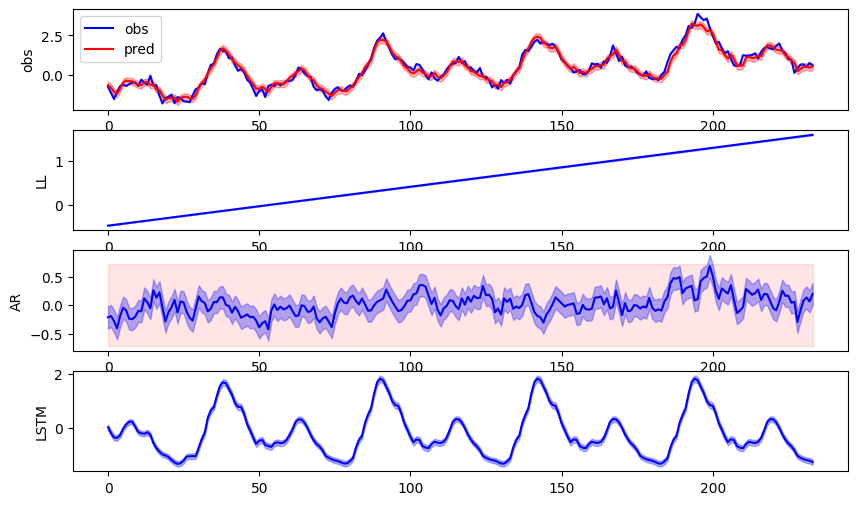

In [91]:
AR_var_stationary = mu_sigma_ar[-1]**2 /(1-mu_phiar[-1]**2)
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

ax0.plot(np.arange(len(obs_norm)),obs_norm,color='b',label=r"obs")
ax0.plot(np.arange(len(mu_preds_norm)),mu_preds_norm,color='r',label=r"pred")
ax0.fill_between(np.arange(len(mu_preds_norm)), np.array(mu_preds_norm) - np.sqrt(var_preds_norm), np.array(mu_preds_norm) + np.sqrt(var_preds_norm), color='red', alpha=0.3)
ax0.set_ylabel('obs')
ax0.legend()

ax1.plot(np.arange(len(mu_LL)),mu_LL,color='b',label=r"LL")
ax1.fill_between(np.arange(len(mu_LL)), np.array(mu_LL) - np.sqrt(var_LL), np.array(mu_LL) + np.sqrt(var_LL), color='blue', alpha=0.3, label='±1 SD')
ax1.set_ylabel('LL')

ax2.fill_between(np.arange(len(mu_AR)), np.zeros_like(len(mu_AR))-3*np.sqrt(AR_var_stationary), np.zeros_like(len(mu_AR))+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
ax2.plot(np.arange(len(mu_AR)),mu_AR,color='b',label=r"AR")
ax2.fill_between(np.arange(len(mu_AR)), np.array(mu_AR) - np.sqrt(var_AR), np.array(mu_AR) + np.sqrt(var_AR), color='blue', alpha=0.3, label='±1 SD')
ax2.set_ylabel('AR')

ax3.plot(np.arange(len(mu_lstm)),mu_lstm,color='b',label=r"LSTM")
ax3.fill_between(np.arange(len(mu_lstm)), np.array(mu_lstm) - np.sqrt(var_lstm), np.array(mu_lstm) + np.sqrt(var_lstm), color='blue', alpha=0.3, label='±1 SD')
ax3.set_ylabel('LSTM')

In [92]:
# # # State-space models: for baseline hidden states
hybrid_test = LSTM_SSM(
    neural_network = net_test,           # LSTM
    baseline = 'AA + AR_fixed', # 'level', 'trend', 'acceleration', 'ETS'
    z_init = init_z,
    Sz_init = init_Sz,
    phi_AR = mu_phiar[-1],
    Sigma_AR = mu_sigma_ar[-1]**2,
)

In [93]:
batch_iter = test_dtl.create_data_loader(batch_size, shuffle=False)
var_y = np.full((batch_size * len(output_col),), sigma_v**2, dtype=np.float32)
obs_norm = []
mu_preds_norm = []
var_preds_norm = []
mu_LL = []
var_LL = []
mu_AR = []
var_AR = []
mu_lstm = copy.deepcopy(init_mu_lstm)
var_lstm = copy.deepcopy(init_var_lstm)
mu_AA = []
var_AA = []

hybrid_test.init_ssm_hs()
for x, y in batch_iter:
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_lstm, var_preds_lstm = mu_lstm,
        input_seq_len = input_seq_len, num_features = num_features,
        )

    # Feed forward
    y_pred, Sy_red, z_pred, Sz_pred, m_pred, v_pred = hybrid_test(mu_x, var_x)
    # Backward
    hybrid_test.backward(mu_obs = y, var_obs = var_y, train_LSTM=False)

    obs_norm.extend(y)
    mu_preds_norm.extend(y_pred[0])
    var_preds_norm.extend(Sy_red[0] + sigma_v**2)
    mu_LL.append(z_pred[0].item())
    var_LL.append(Sz_pred[0][0])
    mu_AA.append(z_pred[2].item())
    var_AA.append(Sz_pred[2][2])
    mu_AR.append(z_pred[-2].item())
    var_AR.append(Sz_pred[-2][-2])
    mu_lstm.extend(m_pred)
    var_lstm.extend(v_pred)
# Delete the first len(init_mu_lstm) elements in mu_lstm and var_lstm
mu_lstm = mu_lstm[len(init_mu_lstm):]
var_lstm = var_lstm[len(init_var_lstm):]

Text(0, 0.5, 'AA')

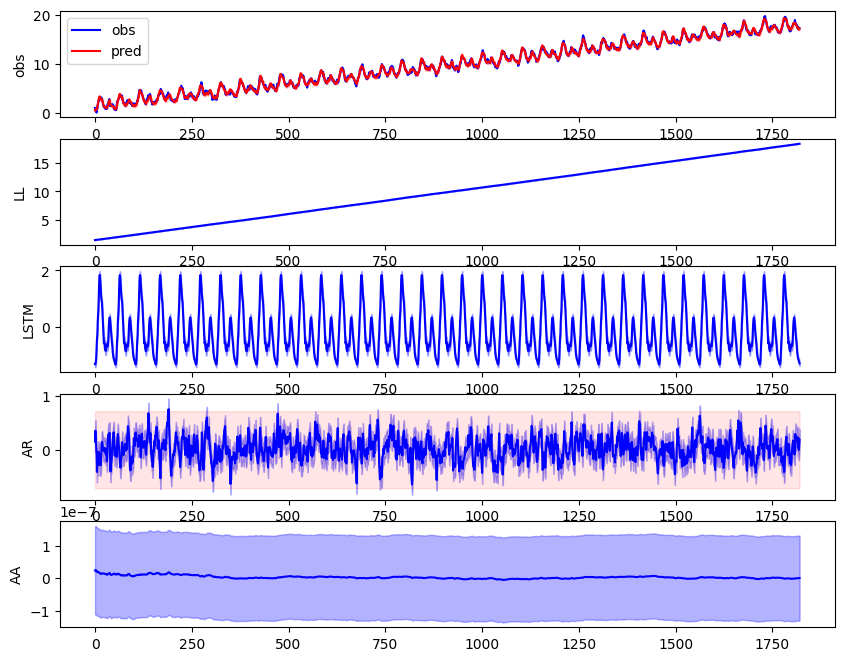

In [94]:
AR_var_stationary = mu_sigma_ar[-1]**2 /(1-mu_phiar[-1]**2)

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(5, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])

ax0.plot(np.arange(len(obs_norm)),obs_norm,color='b',label=r"obs")
ax0.plot(np.arange(len(mu_preds_norm)),mu_preds_norm,color='r',label=r"pred")
ax0.fill_between(np.arange(len(mu_preds_norm)), np.array(mu_preds_norm) - np.sqrt(var_preds_norm), np.array(mu_preds_norm) + np.sqrt(var_preds_norm), color='red', alpha=0.3)
ax0.set_ylabel('obs')
ax0.legend()

ax1.plot(np.arange(len(mu_LL)),mu_LL,color='b',label=r"LL")
ax1.fill_between(np.arange(len(mu_LL)), np.array(mu_LL) - np.sqrt(var_LL), np.array(mu_LL) + np.sqrt(var_LL), color='blue', alpha=0.3, label='±1 SD')
ax1.set_ylabel('LL')

ax2.plot(np.arange(len(mu_lstm)),mu_lstm,color='b',label=r"LSTM")
ax2.fill_between(np.arange(len(mu_lstm)), np.array(mu_lstm) - np.sqrt(var_lstm), np.array(mu_lstm) + np.sqrt(var_lstm), color='blue', alpha=0.3, label='±1 SD')
ax2.set_ylabel('LSTM')

ax3.plot(np.arange(len(mu_AR)),mu_AR,color='b',label=r"AR")
ax3.fill_between(np.arange(len(mu_AR)), np.array(mu_AR) - np.sqrt(var_AR), np.array(mu_AR) + np.sqrt(var_AR), color='blue', alpha=0.3, label='±1 SD')
ax3.fill_between(np.arange(len(mu_AR)), np.zeros_like(len(mu_AR))-3*np.sqrt(AR_var_stationary), np.zeros_like(len(mu_AR))+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
ax3.set_ylabel('AR')

ax4.plot(np.arange(len(mu_AA)),mu_AA,color='b',label=r"AA")
ax4.fill_between(np.arange(len(mu_AA)), np.array(mu_AA) - np.sqrt(var_AA), np.array(mu_AA) + np.sqrt(var_AA), color='blue', alpha=0.3, label='±1 SD')
ax4.set_ylabel('AA')

## 4. generate time series for RL agent training

In [111]:
num_syn_ts = 200
syn_ts_len = hyperparameters['kernel']['period'] * 6
syn_ts_all = []

hybrid_gen = LSTM_SSM(
    neural_network = net_test,           # LSTM
    baseline = 'AA + AR_fixed', # 'level', 'trend', 'acceleration', 'ETS'
    z_init = init_z,
    Sz_init = init_Sz,
    phi_AR = mu_phiar[-1],
    Sigma_AR = mu_sigma_ar[-1]**2,
)

In [112]:
def normalize_date(date_time_i, mean, std):
    for time_cov in time_covariates:
        if time_cov == 'hour_of_day':
            hour_of_day = date_time_i.astype('datetime64[h]').astype(int) % 24
            output = hour_of_day
        elif time_cov == 'day_of_week':
            day_of_week = date_time_i.astype('datetime64[D]').astype(int) % 7
            output = day_of_week
        elif time_cov == 'week_of_year':
            week_of_year = date_time_i.astype('datetime64[W]').astype(int) % 52 + 1
            output = week_of_year
        elif time_cov == 'month_of_year':
            month_of_year = date_time_i.astype('datetime64[M]').astype(int) % 12 + 1
            output = month_of_year
        elif time_cov == 'quarter_of_year':
            month_of_year = date_time_i.astype('datetime64[M]').astype(int) % 12 + 1
            quarter_of_year = (month_of_year - 1) // 3 + 1
            output = quarter_of_year
        elif time_cov == 'day_of_year':
            day_of_year = date_time_i.astype('datetime64[D]').astype(int) % 365
            output = day_of_year

    output = Normalizer.standardize(data=output, mu=mean, std=std)
    return output

In [113]:
for j in tqdm(range(num_syn_ts)):
    syn_ts_i=copy.deepcopy(last_seq_obs)
    gen_datetime = np.array(val_datetime_values, dtype='datetime64')
    datetime_values_tosave = []
    for i in range(25):
        datetime_values_tosave.append(gen_datetime[-(25-i)])
    current_date_time = gen_datetime[-1] + np.timedelta64(7, 'D')
    datetime_values_tosave.append(current_date_time)

    x = copy.deepcopy(last_lstm_x)
    gen_mu_lstm = copy.deepcopy(init_mu_lstm)
    gen_var_lstm = copy.deepcopy(init_var_lstm)

    hybrid_gen.init_ssm_hs()
    hybrid_gen.z = copy.deepcopy(init_z)
    hybrid_gen.Sz = copy.deepcopy(init_Sz)

    for i in range(syn_ts_len):
        # remove the first two elements in x, and add two new at the end
        gen_datetime = np.append(gen_datetime, [gen_datetime[-1] + np.timedelta64(7, 'D')]).reshape(-1, 1)
        next_date = normalize_date(gen_datetime[-1], train_dtl.x_mean[-1], train_dtl.x_std[-1])
        x[0:-2] = x[2:]
        x[-2] = gen_mu_lstm[-1].item()
        x[-1] = next_date.item()

        x_input = np.copy(x)
        mu_x_, var_x_ = process_input_ssm(
                mu_x = x_input, mu_preds_lstm = gen_mu_lstm, var_preds_lstm = gen_var_lstm,
                input_seq_len = input_seq_len, num_features = num_features,
                )
        # Feed forward
        y_pred, Sy_red, z_prior, Sz_prior, m_pred, v_pred = hybrid_gen(mu_x_, var_x_)
        hybrid_gen.backward(mu_obs = np.nan, var_obs = np.nan, train_LSTM=False)

        # Sample
        z_sample = np.random.multivariate_normal(z_prior.flatten(), Sz_prior)
        y_sample = np.dot(hybrid_gen.F, z_sample)

        obs_sample = normalizer.unstandardize(
            y_sample, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )

        gen_mu_lstm.extend(m_pred)
        gen_var_lstm.extend(v_pred)
        syn_ts_i.extend(obs_sample)
        current_date_time = gen_datetime[-1] + np.timedelta64(7, 'D')
        datetime_values_tosave.append(current_date_time[0])

    syn_ts_all.append(syn_ts_i)


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [06:55<00:00,  2.08s/it]


In [114]:
with open('data/synthetic_ts/RLDS_syn_datetime_200episodes.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['date_time'])  # Write header
    for dt in datetime_values_tosave:
        writer.writerow([dt])  # Write formatted datetime string

transposed_data = list(zip(*syn_ts_all))
import csv

with open('data/synthetic_ts/RLDS_syn_observation_200episodes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(transposed_data)

/var/folders/vv/62ff9wx97g72zr4_20vx1q3h0000gn/T/ipykernel_24221/2106826567.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


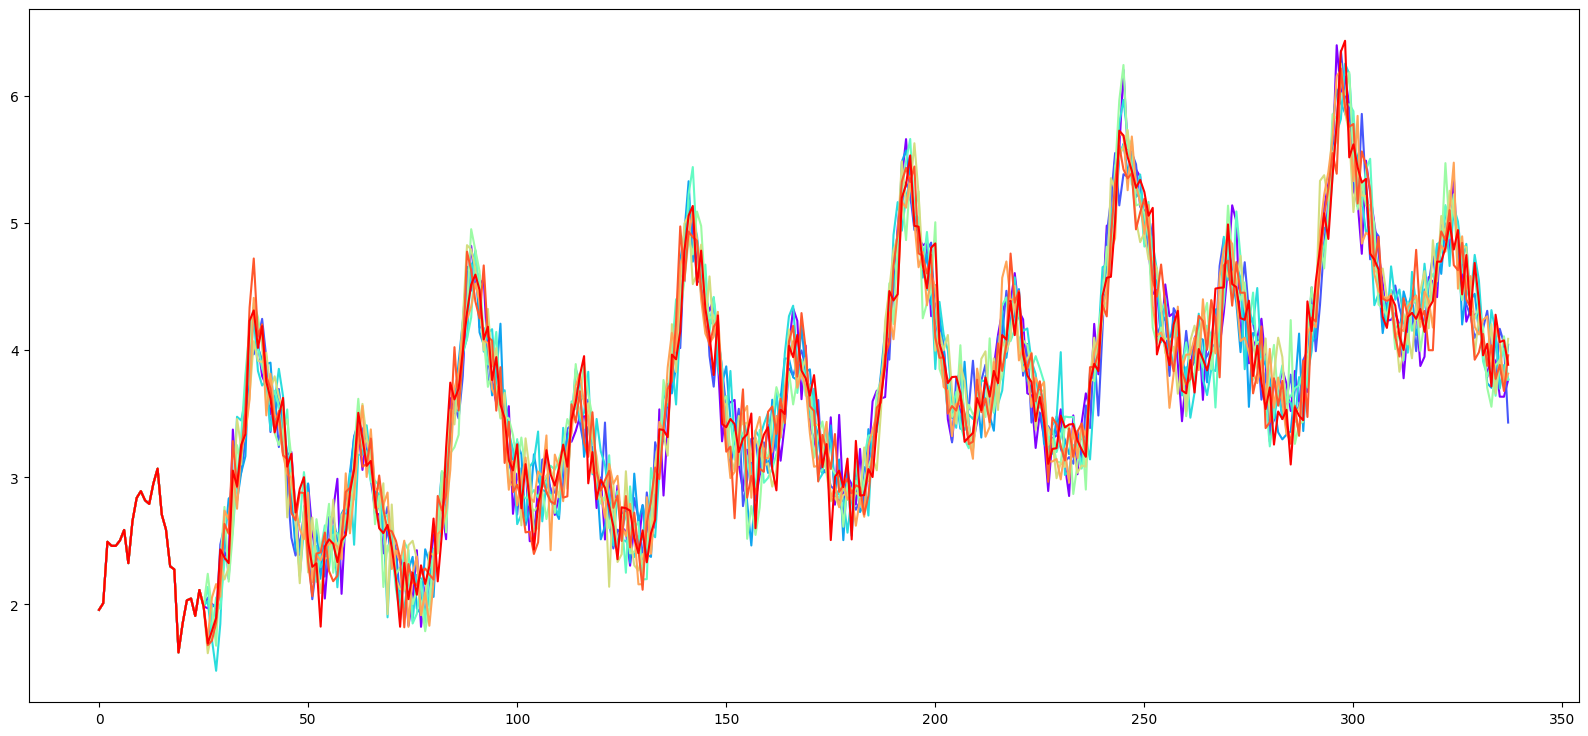

In [115]:
# Plot the first 10 time series in syn_ts_all
def get_cmap(n, name='rainbow'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

COLORS = get_cmap(10)
plt.figure(figsize=(20, 9))
for i in range(10):
    plt.plot(syn_ts_all[i], color = COLORS(i))
plt.show()